In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from pathlib import Path, PurePath
import pytz

# Data Understanding and Preparation of the ISMN Data

The goal is to generate descriptive statistics, plot, and impute missing values for the <10 cm depth soil temperature variable for all ISMN sensors in `data/raw`.

---

### Table of Contents

1. **1: Setup**
2. **2: Data Understanding**
   - *2.1: Initial Data Collection*
   - *2.2: Data Description*
   - *2.3: Data Exploration*
3. **3: Data Preparation**
   - *3.1: Data Selection*
   - *3.2 Air Route Data Integration*
   - *3.3: Construct Final Datasets*
   - *3.4 Merge Air and Rail Route Data*
   - *3.5 Validation and Integrity Check of Route Dataset*

---

In [21]:
# key variables
max_depth = 0.10 # in m, exclusive
short_variable = 'ts' # soil temperature
long_variable = 'soil_temp'
nan_gap_limit = 72 # hours, lower threshold for reporting gaps of missing data

# path variables
raw_data_path = Path('data/raw')
cleaned_data_path = Path('data/cleaned')

# data directory names
dir_aberdeen = Path('Aberdeen-35-WNW')
dir_jamestown = Path('Jamestown-38-WSW')
dir_gobblers_knob = Path('GobblersKnob')
dir_nenana = Path('Nenana')
dir_L23 = Path('L23')
dir_L38 = Path('L38')
dir_NST_07 = Path('NST-07')
dir_NST_09 = Path('NST-09')
dir_SOD012 = Path('SOD012')
dir_SOD103 = Path('SOD103')

#### Define functions to be used in later cells

In [48]:
def collect_data(path: Path, depth: float, short_feature: str, long_feature: str) -> pd.DataFrame:
    """
    Collect data for a station into a list then merge into a single df
    :param path: path to directory for a station
    :param depth: max depth in meters, exclusive
    :param short_feature: abbreviated variable name
    :param long_feature: full variable name
    :return: combined_df
    """
    col_names = ['UTC_date', 'UTC_time', long_feature, 'ISMN_data_quality', 'provider_data_quality']

    dfs = []
    for file in path.iterdir():
        filename = file.name
        filename_split = filename.split('_')

        # skip if file extension is not .stm
        if not filename.endswith('.stm'):
            continue

        # skip if file contains wrong variable or soil depth
        if filename_split[3] != short_feature or float(filename_split[4]) >= depth:
            continue

        df = pd.read_csv(file, sep=' ', header=None, skiprows=1, names=col_names)
        dfs.append(df)

    if len(dfs) == 0:
        raise Exception(f'No data found for {path.name}, depth={depth}, variable={long_feature}')

    combined_df = pd.concat(dfs, axis=0, ignore_index=True)

    return combined_df

def create_timestamp_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a UTC timestamp column.
    ISMN has the date and time in separate columns.
    :param df:
    :return: df with timestamp column
    """
    df_copy = df.copy()

    df_copy['UTC_timestamp'] = df_copy['UTC_date'].astype(str) + ' ' + df_copy['UTC_time'].astype(str)
    df_copy['UTC_timestamp'] = pd.to_datetime(df_copy['UTC_timestamp'], format='%Y/%m/%d %H:%M')
    df_copy = df_copy.drop(columns=['UTC_date', 'UTC_time'])
    df_copy.set_index('UTC_timestamp', inplace=True)
    df_copy.index = df_copy.index.tz_localize('UTC')

    return df_copy

def convert_nan(df: pd.DataFrame, long_feature: str) -> pd.DataFrame:
    """
    Create proper nan values in the df.
    ISMN fills nan with -9999.
    provider_data_quality column not used because inconsistent across networks.
    :param df:
    :param long_feature: full variable name
    :return: df with proper nan values
    """
    df_copy = df.copy()

    df_copy.loc[df_copy['ISMN_data_quality'] != 'G', long_feature] = np.nan

    return df_copy

def report_nan_count(df: pd.DataFrame, long_feature: str) -> None:
    """
    Prints the total number of nan values in the df and percent missing.
    :param df:
    :param long_feature: full variable name
    :return: None
    """
    # total nulls
    na_count = df.isnull().sum()[long_feature]
    print(f'There are {na_count} nulls out of {len(df)} datapoints ({round(na_count/len(df),2)}% missing).')

def get_nan_gaps(df: pd.DataFrame, long_feature: str) -> pd.DataFrame:
    f"""
    Determines nan gaps in the long_feature column of the df.
    Uses the existing UTC_timestamp as the index for start and end timestamps.
    :param df:
    :param long_feature: full variable name
    :return: df with
        - start_timestamp: timestamp of the first row in the gap
        - end_timestamp: timestamp of the last row in the gap
        - gap_length_hours: length of the gap in hours
        - prev_(long_feature): value before the gap
        - next_(long_feature): value after the gap
    """
    if long_feature not in df.columns:
        raise Exception(f'Missing required column "{long_feature}".')

    df_copy = df.copy()

    # Step 1: Fill forward and backward for prev_temp and next_temp
    df_copy[f'prev_{long_feature}'] = df_copy[long_feature].ffill()
    df_copy[f'next_{long_feature}'] = df_copy[long_feature].bfill()

    # Step 2: Identify gaps (NaN in long_feature)
    mask = df_copy[long_feature].isna()

    # Step 3: Create group IDs for consecutive NaNs
    group_ids = (~mask).cumsum()
    group_ids = group_ids.where(~mask, group_ids.shift(1).fillna(0))
    group_ids = group_ids.fillna(0).astype(int)

    # Step 4: Group by group_ids and filter for groups with NaNs
    grouped = df_copy.groupby(group_ids)

    results = []
    for _, group in grouped:
        if group[long_feature].isna().any():
            start_row = group.iloc[0]
            end_row = group.iloc[-1]
            start_ts = start_row.name + datetime.timedelta(hours=1)
            end_ts = end_row.name
            gap_length = len(group) - 1
            prev_val = start_row[f'prev_{long_feature}']
            next_val = end_row[f'next_{long_feature}']
            results.append({
                'start_timestamp': start_ts,
                'end_timestamp': end_ts,
                'gap_length_hours': gap_length,
                f'prev_{long_feature}': prev_val,
                f'next_{long_feature}': next_val
            })

    results = pd.DataFrame(results)
    results = results[results['gap_length_hours'] > 1]

    return results

def add_missed_transitions_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds column indicating if an F/T transition occurred during a NaN gap.
    :param df: must contain soil_temp data
    :return: df with added boolean column 'possible_transition'
    """
    required_cols = ['start_timestamp', 'end_timestamp', 'gap_length_hours', 'prev_soil_temp', 'next_soil_temp']
    if not set(required_cols) <= set(df.columns):
        raise Exception('df does not contain all required columns.')

    df_copy = df.copy()

    df_copy['possible_transition'] = (
            abs(df_copy['prev_soil_temp'] + df_copy['next_soil_temp'])
            < df_copy[['prev_soil_temp', 'next_soil_temp']].abs().max(axis=1)
    )

    return df_copy

def line_plot(df: pd.DataFrame, long_feature: str, start=None, end=None) -> None:
    """
    Plots a line plot of long_feature vs the index.
    If end given but not start, plot will begin from the earliest timestamp in the df.
    :param df:
    :param long_feature: full variable name
    :param start: naive datetime.datetime object
    :param end: naive datetime.datetime object
    :return: None
    """
    # check start and end inputs
    if start is not None:
        if type(start) is not datetime.datetime:
            raise Exception(f'start must be a datetime.datetime object.')
        start = start.replace(tzinfo=pytz.UTC)
    if end is not None:
        if type(end) is not datetime.datetime:
            raise Exception(f'end must be a datetime.datetime object.')
        end = end.replace(tzinfo=pytz.UTC)

    # set date range for plot
    if start is None and end is not None:
        time_range = df.index[df.index < end]
    elif start is not None and end is not None:
        time_range = df.index[start < df.index < end]
    else: # default to plotting all records
        time_range = df.index

    df_slice = df.loc[time_range]
    plt.plot(df_slice.index, df_slice[long_feature])
    plt.title(f'{str(dir_aberdeen)}, {long_feature}')
    plt.ylabel(long_feature)
    plt.xlabel('Date')
    plt.xticks(rotation=30)

    if long_feature == 'soil_temp':
        plt.axhline(y=0, color='k')

    plt.show()


### Aberdeen-35-WNW

In [14]:
# preprocess data
aberdeen_df = collect_data(raw_data_path / dir_aberdeen, max_depth, short_variable, long_variable)
aberdeen_df = create_timestamp_col(aberdeen_df)
aberdeen_df = convert_nan(aberdeen_df, long_variable)

aberdeen_df.describe()

,soil_temp
count,140180.000000
mean,7.540031
std,8.418096
min,-10.600000
25%,-0.200000
50%,6.600000
75%,16.000000
max,25.500000


In [15]:
# inspect data
aberdeen_df.head()

,soil_temp,ISMN_data_quality,provider_data_quality
UTC_timestamp,,,
2009-10-28 02:00:00+00:00,6.1,G,M
2009-10-28 03:00:00+00:00,6.1,G,M
2009-10-28 04:00:00+00:00,6.0,G,M
2009-10-28 05:00:00+00:00,6.0,G,M
2009-10-28 06:00:00+00:00,5.9,G,M


In [16]:
report_nan_count(aberdeen_df, long_variable)

There are 2571 nulls out of 142751 datapoints (0.02% missing).


In [17]:
aberdeen_nan_df = get_nan_gaps(aberdeen_df, long_variable)
aberdeen_nan_df = add_missed_transitions_col(aberdeen_nan_df)
aberdeen_nan_df

,start_timestamp,end_timestamp,gap_length_hours,prev_soil_temp,next_soil_temp,possible_transition
3,2010-03-19 20:00:00+00:00,2010-03-19 21:00:00+00:00,2,-0.2,-0.2,False
5,2010-04-07 08:00:00+00:00,2010-04-20 16:00:00+00:00,321,5.0,8.0,False
6,2010-05-23 16:00:00+00:00,2010-05-23 23:00:00+00:00,8,13.6,16.8,False
10,2011-05-13 18:00:00+00:00,2011-05-14 00:00:00+00:00,7,6.9,7.5,False
13,2011-07-20 21:00:00+00:00,2011-07-20 22:00:00+00:00,2,21.9,22.2,False
...,...,...,...,...,...,...
89,2025-12-12 18:00:00+00:00,2025-12-13 17:00:00+00:00,24,2.7,2.1,False
91,2025-12-13 23:00:00+00:00,2025-12-14 17:00:00+00:00,19,2.0,1.6,False
92,2025-12-31 00:00:00+00:00,2026-01-01 00:00:00+00:00,25,0.2,0.2,False
93,2026-01-02 09:00:00+00:00,2026-01-05 17:00:00+00:00,81,0.0,0.0,False


There are six NaN gaps longer than 72 hours in duration. There is one NaN gap that contained at least one F/T transition, which is from 2021-11-03 to 2022-01-01 (1400 hour duration).

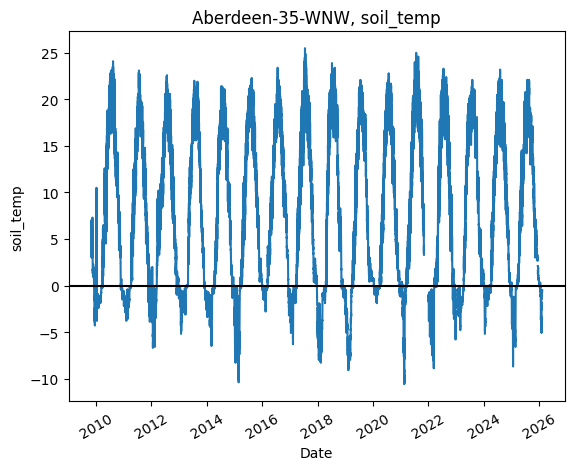

In [50]:
line_plot(aberdeen_df, long_variable)

Inspection of the plot shows that the dataset contains at least 32 F/T transitions. However, there seems to be some odd behaviour around the winter of 2010.

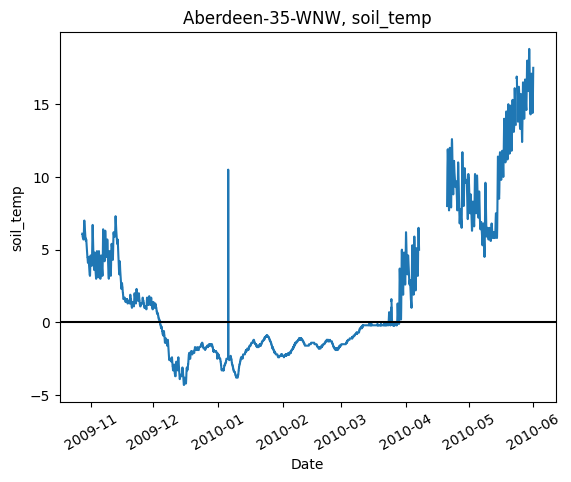

In [49]:
line_plot(aberdeen_df, long_variable, end=datetime.datetime(2010, 6, 1))

### Nenana

In [9]:
df_nenana = collect_data(raw_data_path / dir_nenana, max_depth, short_variable, long_variable)